# Tutorial 5 - CodeGen and External Function Interfacing
- Video: https://www.youtube.com/watch?v=nXA2EbJS8fI

- There are many other existing Agentic Frameworks like LangChain / LangGraph, LlamaIndex that have many pre-established tools
- AgentJo provides an easy way to interface with them and input them directly into AgentJo Agents!
- We also show how to implement the Code as Actions agent (Executable Code Actions Elicit Better LLM Agents (Wang et al, 2024)
- https://arxiv.org/abs/2402.01030

# Setup Guide

## Step 1: Install AgentJo

In [1]:
# !pip install agentjo

## Step 2: Import required functions and setup relevant API keys for your LLM

In [2]:
# Set up API key and do the necessary imports
from agentjo import *
import os

from dotenv import load_dotenv
load_dotenv()

True

## Step 3: Define your own LLM
- Take in a `system_prompt`, `user_prompt`, and outputs llm response string

In [3]:
def llm(system_prompt: str, user_prompt: str) -> str:
    ''' Here, we use OpenAI for illustration, you can change it to your own LLM '''
    # ensure your LLM imports are all within this function
    from openai import OpenAI
    
    # define your own LLM here
    client = OpenAI()
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        temperature = 0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content

In [4]:
# Verify that llm function is working
llm(system_prompt = 'You are a classifier to classify the sentiment of a sentence', 
    user_prompt = 'It is a hot and sunny day')

'Neutral'

# LangChain Structured Tools Interface with AgentJo
- If User defines a function in LangChain, simply just add <fn_name>.func to AgentJo Agent

In [5]:
from langchain_core.tools import tool

@tool
def add(num1: int, num2: int) -> int:
    """Adds num1 and num2."""
    return num1 + num2


@tool
def multiply(num1: int, num2: int) -> int:
    """Multiplies num1 and num2."""
    return num1 * num2


tools = [add, multiply]

In [6]:
from agentjo import Agent
agent = Agent('Math Whiz', 'Does calculations',
             llm = llm).assign_functions([add.func, multiply.func])

In [7]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Passes the final output to the user\nInput: []\nOutput: {}\n',
 "Name: add\nDescription: Adds <num1: int> and <num2: int>.\nInput: ['num1', 'num2']\nOutput: {'output_1': 'int'}\n",
 "Name: multiply\nDescription: Multiplies <num1: int> and <num2: int>.\nInput: ['num1', 'num2']\nOutput: {'output_1': 'int'}\n"]

In [8]:
agent.run('Calculate 3*5 + 3')

Observation: No subtasks have been completed yet for the assigned task of calculating 3*5 + 3.
Thoughts: To complete the assigned task, I need to first perform the multiplication of 3 and 5, and then add 3 to the result.
Subtask identified: Multiply 3 and 5 to get the first part of the calculation.
Calling function multiply with parameters {'num1': 3, 'num2': 5}
> {'output_1': 15}

Observation: The multiplication of 3 and 5 has been completed, resulting in 15.
Thoughts: Now, I need to add 3 to the result of the multiplication to complete the calculation for the assigned task.
Subtask identified: Add 15 and 3 to get the final result of the assigned task.
Calling function add with parameters {'num1': 15, 'num2': 3}
> {'output_1': 18}

Observation: The multiplication of 3 and 5 has been completed, resulting in 15. Additionally, the addition of 15 and 3 has been completed, yielding a final result of 18.
Thoughts: Since the Assigned Task has been fully completed with the final result of 18,

[{'output_1': 15}, {'output_1': 18}]

# LangChain Community Tools Interface with AgentJo
- See https://python.langchain.com/v0.2/docs/integrations/providers/ for full list
- Wikipedia
- Python REPL (not that great to run many things - have created my own in AgentJo)

In [9]:
# !pip -q install wikipedia

In [10]:
def wikipedia_tool(search_query: str) -> str:
    ''' Uses search_query and returns text from wikipedia '''
    from langchain.tools import WikipediaQueryRun
    from langchain.utilities import WikipediaAPIWrapper

    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(search_query)

In [11]:
wikipedia_tool('Joe Biden')[:100]

'Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American retired '

# LlamaIndex Function Interface with AgentJo
- If User defines a function in LlamaIndex, simply just add <fn_name>.fn to AgentJo Agent
- TODO: Add structure for other kinds of functions in LlamaIndex

In [12]:
# !pip install llama-index

In [13]:
from llama_index.core.tools import FunctionTool

def get_weather(location: str) -> str:
    """Useful for getting the weather for a given location"""
    return 'Sunny'
    ...

tool = FunctionTool.from_defaults(
    get_weather,
    # async_fn=aget_weather,  # optional!
)

In [14]:
agent = Agent('Weather Agent', 'Returns the Weather',
             llm = llm).assign_functions(tool.fn)

In [15]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Passes the final output to the user\nInput: []\nOutput: {}\n',
 "Name: get_weather\nDescription: Useful for getting the weather for a given <location: str>\nInput: ['location']\nOutput: {'output_1': 'str'}\n"]

In [16]:
agent.run('What is the weather in Miami?')

Observation: No subtasks have been completed yet for the assigned task of finding the weather in Miami.
Thoughts: To complete the assigned task, I need to use the get_weather function to retrieve the current weather for Miami.
Subtask identified: Use the get_weather function to obtain the weather information for Miami.
Calling function get_weather with parameters {'location': 'Miami'}
> {'output_1': 'Sunny'}

Observation: The weather in Miami has been successfully retrieved and is reported as Sunny.
Thoughts: Since the weather information for Miami is already obtained, the next step is to provide this information to the user.
Subtask identified: End Task
Task completed successfully!



[{'output_1': 'Sunny'}]

# AgentJo Custom Tools
- Some initial tools AgentJo can provide are as follows:
    - Code generator: `python_generator_tool`
    - Code executor: `python_run_tool`
    - Code debugger: `python_debug_tool`
    - Code generator, executor and debugger combined: `python_generate_and_run_code_tool`

In [17]:
shared_variables = {'agent': Agent('Generalist Agent', 'Does Everything', llm = llm).assign_functions([wikipedia_tool])}

In [63]:
def python_generator_tool(shared_variables, instruction: str):
    '''Generate code only based on instruction without any additional context.
Ensure that you define all variables and list out all imports.
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
Do not define any new functions
You are able to use all Equipped Functions except use_llm and end_task
The output of Equipped Function will be in a dictionary format
Ensure all required output are in print()'''
    
    agent = shared_variables['agent']
    
    return strict_json(f'''Generate code based only on ```{instruction}``` without additional context.
Ensure that you define all variables and list out all imports.
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
Do not define any new functions
You are able to use the following Equipped Functions: 
```{agent.list_functions(
fn_list = [agent.function_map[function_name] for function_name in agent.function_map if function_name not in ['use_llm', 'end_task']])}
```
The output of Equipped Function will be in a dictionary format
You must use Equipped Functions whenever possible
Ensure all required output are in print()
Use "###Code###" for json output field''',
                       '',
                                     output_format = {'Code': 'type: code'},
                      llm = agent.llm)

In [64]:
python_generator_tool(shared_variables, 'What are the first 3 primes by calculation?')

Filtered Function Names: wikipedia_tool


{'Code': 'import math\n\n# Initialize variables\nprimes = []\nnum = 2\n\n# Calculate the first 3 prime numbers\nwhile len(primes) < 3:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        primes.append(num)\n    num += 1\n\n# Print the first 3 prime numbers\nprint(primes)'}

In [65]:
def python_run_tool(shared_variables, code_snippet: str) -> str:
    '''Runs code_snippet and outputs the result of all print statements'''
    import sys
    import io
    import math
    import numpy
    import random
    import datetime
    import re
    import matplotlib
    import pandas
    import plotly
    
    agent = shared_variables['agent']
    
    # wrap external functions to pass in shared_variables as well
    def external_function_wrapper(function_name, shared_variables):
        def external_function(**function_params):
            return agent.function_map[function_name](shared_variables=shared_variables, **function_params)
        return external_function
    
    # Capture the output
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()

    try:
        # Safe environment to execute the user code
        allowed_globals = {
            '__builtins__': {
                'print': print,
                'range': range,
                'len': len,
                'int': int,
                'float': float,
                'str': str,
                'list': list,
                'dict': dict,
                'set': set,
                'tuple': tuple,
                'abs': abs,
                'min': min,
                'max': max,
                'sum': sum,
                'any': any,
                'all': all,
                'sorted': sorted,
                'zip': zip,
                'map': map,
                'filter': filter,
                '__import__': __import__,
                'math': math,  # Allow access to the math module
                'datetime': datetime, # Allow access to datetime module
                'random': random, # Allow access to random module
                'numpy': numpy, # Allow access to numpy module
                're': re,
                'matplotlib': matplotlib,
                'pandas': pandas,
                'plotly': plotly
            }
        }
        
        # add in equipped functions one by one
        for function_name in agent.function_map:
            if function_name not in ['use_llm', 'end_task', 'python_generate_and_run_code_tool']:
                allowed_globals['__builtins__'][function_name] = external_function_wrapper(function_name, shared_variables)

        safe_locals = {}

        exec(code_snippet, allowed_globals, safe_locals)
        output = sys.stdout.getvalue()
    except Exception as e:
        output = f"Error: {e}"
    finally:
        # Restore the original stdout
        sys.stdout = old_stdout

    return output

In [66]:
python_run_tool({'agent': Agent('Generalist Agent', 'Does Everything', llm = llm)},
                 'print("This is a great tool to debug and run code!")\nprint("Awesome!")')

'This is a great tool to debug and run code!\nAwesome!\n'

In [67]:
python_debug_tool = Function('''Debugs Python Code and returns corrected code.
Instruction: <instruction: str>
Current Code: <python_code: str>
Error Message: <error_msg: str>''',
                                 output_format = {'Thoughts': 'How to correct code', 'Corrected Code': 'type: code'}, 
                             fn_name = 'python_debug_tool', 
                             llm = llm)

In [68]:
python_debug_tool('Print result', 'result = 3print(result)', 'invalid decimal literal (<string>, line 1)')

{'Thoughts': 'The code has a syntax error due to the incorrect placement of the number and the print function. It should be corrected to properly assign a value to result and then print it.',
 'Corrected Code': 'result = 3\nprint(result)'}

## Combining all Python Code tools into one
- This is like a rule-based agent, doing the three functions inside it, so that we don't have to keep passing in code as input variable to the functions
- This is also a context-based function, taking in agent's overall task and subtasks completed via shared_variables

In [69]:
# Uses LLM to generate Code
def python_generate_and_run_code(shared_variables, instruction: str) -> str:
    ''' Generates and runs code based on instruction. 
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
You can use all Equipped Functions except use_llm and end_task. 
Returns 1) the result of all print statements in code, or error messages, and 2) the code '''
    # from termcolor import colored
    
    # Append context to tool
    if shared_variables and 'agent' in shared_variables:
        instruction = f"Context: {shared_variables['agent'].overall_task}\nPrevious Subtasks: {shared_variables['agent'].subtasks_completed}\nInstruction: {instruction}"
    # Generate Code
    python_code = python_generator_tool(shared_variables, instruction)['Code']
    # print(colored(f'Generated code: ```{python_code}```', 'magenta'))
    
    # Run and Debug Code
    for _ in range(3):
        output = python_run_tool(shared_variables, python_code)

        if output[:5] == "Error":
            debugged_code = python_debug_tool(instruction, python_code, output)
            python_code = debugged_code['Corrected Code']
            # print(colored(output, 'red'))
            # print(colored(f'Debugged code: ```{python_code}```', 'magenta'))
        else:
            break
            
    return output, python_code

# Make this function compulsory
python_generate_and_run_code_tool = Function(
    external_fn = python_generate_and_run_code, 
    fn_name = 'python_generate_and_run_code_tool', 
    is_compulsory = True)

In [70]:
python_generate_and_run_code_tool(shared_variables = shared_variables, instruction = 'Give me first 10 primes, without 2 and 5')

Filtered Function Names: wikipedia_tool


{'output_1': '[3, 5, 7, 11, 13, 17, 19, 23, 29, 31]\n',
 'output_2': 'import numpy as np\n\nprimes = []\nnum = 3\nwhile len(primes) < 10:\n    is_prime = True\n    for i in range(3, int(np.sqrt(num)) + 1, 2):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        primes.append(num)\n    num += 2\n\nprint(primes)'}

# General CodeGen showcase

In [71]:
agent = Agent('Generalist Agent', 
'''Helps user with tasks. When deterministic output or plots are needed, generate and run code. Do not use LLM for calculations.''',
             summarise_subtasks_count = 10,
             llm = llm).assign_functions(
    [wikipedia_tool, python_generate_and_run_code_tool])

In [72]:
agent.reset()
agent.run('John has 5 apples. John received another 21 more from Mary, and gave 10 to Tim. How many apples does John have at the end?')

Observation: No subtasks have been completed yet for the assigned task regarding the number of apples John has.
Thoughts: To complete the assigned task, I need to calculate the total number of apples John has after receiving and giving away apples. This involves simple arithmetic operations.
Subtask identified: Generate and run code to calculate the final number of apples John has after receiving 21 apples and giving away 10 apples.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate and run code to calculate the final number of apples John has after receiving 21 apples and giving away 10 apples.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool
> {'output_1': '16\n', 'output_2': 'import numpy as np\n\n# Initial number of apples\njohn_apples = 5\n\n# Apples received from Mary\nreceived_apples = 21\n\n# Apples given to Tim\ngiven_apples = 10\n\n# Final number of apples\nfinal_apples = john_apples + received_apples - giv

[{'output_1': '16\n',
  'output_2': 'import numpy as np\n\n# Initial number of apples\njohn_apples = 5\n\n# Apples received from Mary\nreceived_apples = 21\n\n# Apples given to Tim\ngiven_apples = 10\n\n# Final number of apples\nfinal_apples = john_apples + received_apples - given_apples\n\nprint(final_apples)'}]

In [73]:
agent.reply_user()

To determine how many apples John has at the end, we start with the initial number of apples he has, which is 5. John then receives 21 apples from Mary, bringing his total to 5 + 21 = 26 apples. After that, John gives away 10 apples to Tim. Therefore, the final calculation is 26 - 10 = 16 apples. Thus, John has 16 apples at the end.


'To determine how many apples John has at the end, we start with the initial number of apples he has, which is 5. John then receives 21 apples from Mary, bringing his total to 5 + 21 = 26 apples. After that, John gives away 10 apples to Tim. Therefore, the final calculation is 26 - 10 = 16 apples. Thus, John has 16 apples at the end.'

Observation: No subtasks have been completed yet for the task of plotting the graph of y = 2x^2.
Thoughts: To complete the task, I need to generate code that will create a plot for the function y = 2x^2. This involves defining the range of x values, calculating the corresponding y values, and then using a plotting library to visualize the graph.
Subtask identified: Generate and run code to plot the graph of y = 2x^2 using a suitable plotting library.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate and run code to plot the graph of y = 2x^2 using a suitable plotting library.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool


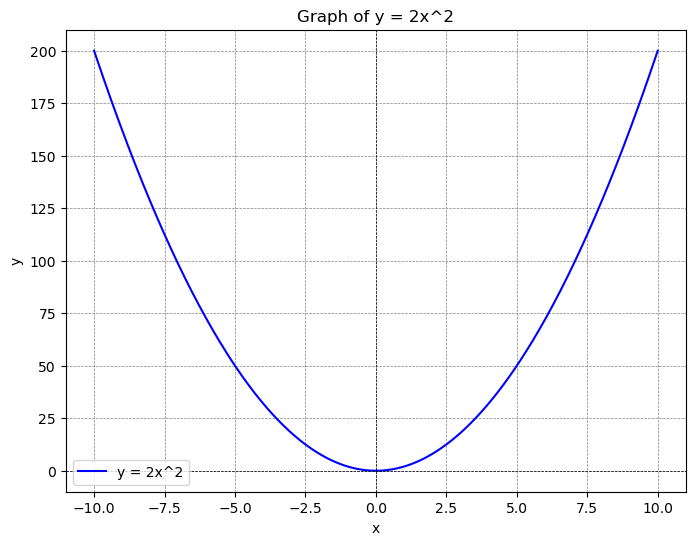

> {'output_1': '', 'output_2': "import numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the range of x values\nx = np.linspace(-10, 10, 400)\n# Define the function y = 2x^2\ny = 2 * x**2\n\n# Create the plot\nplt.figure(figsize=(8, 6))\nplt.plot(x, y, label='y = 2x^2', color='blue')\nplt.title('Graph of y = 2x^2')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.axhline(0, color='black',linewidth=0.5, ls='--')\nplt.axvline(0, color='black',linewidth=0.5, ls='--')\nplt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)\nplt.legend()\nplt.show()"}

Observation: The code to plot the graph of y = 2x^2 has been generated and run successfully, but the output of the plot has not been displayed to the user yet.
Thoughts: To complete the assigned task, I need to pass the final output of the plot to the user, as the graph has already been created and displayed.
Subtask identified: End Task
Task completed successfully!



[{'output_1': '',
  'output_2': "import numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the range of x values\nx = np.linspace(-10, 10, 400)\n# Define the function y = 2x^2\ny = 2 * x**2\n\n# Create the plot\nplt.figure(figsize=(8, 6))\nplt.plot(x, y, label='y = 2x^2', color='blue')\nplt.title('Graph of y = 2x^2')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.axhline(0, color='black',linewidth=0.5, ls='--')\nplt.axvline(0, color='black',linewidth=0.5, ls='--')\nplt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)\nplt.legend()\nplt.show()"}]

In [74]:
agent.reset()
agent.run('Plot me a graph of y = 2x^2')

In [75]:
agent.reset()
agent.run('What are the first 10 prime numbers?')

Observation: No subtasks have been completed yet for the task of identifying the first 10 prime numbers.
Thoughts: To complete the task, I need to generate a list of the first 10 prime numbers. This can be done by writing a simple algorithm to find prime numbers and then running the code to get the result.
Subtask identified: Generate and run code to calculate the first 10 prime numbers using a suitable algorithm.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate and run code to calculate the first 10 prime numbers using a suitable algorithm.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool
> {'output_1': '[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n', 'output_2': 'import math\n\n# Initialize variables\nprime_numbers = []\nnum = 2\n\n# Loop until we find the first 10 prime numbers\nwhile len(prime_numbers) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is

[{'output_1': '[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n',
  'output_2': 'import math\n\n# Initialize variables\nprime_numbers = []\nnum = 2\n\n# Loop until we find the first 10 prime numbers\nwhile len(prime_numbers) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        prime_numbers.append(num)\n    num += 1\n\n# Print the first 10 prime numbers\nprint(prime_numbers)'}]

In [76]:
agent.reset()
agent.run('Who is Joe Biden and how old is he now based on calculation?')

Observation: No subtasks have been completed yet for the task of identifying who Joe Biden is and calculating his current age.
Thoughts: To complete the task, I need to gather information about Joe Biden and perform a calculation to determine his current age based on the current date.
Subtask identified: Search for information about Joe Biden on Wikipedia to gather relevant details about his identity and background.
Calling function wikipedia_tool with parameters {'search_query': 'Joe Biden site:wikipedia.org'}
> {'output_1': 'Page: Inauguration of Joe Biden\nSummary: The inauguration of Joe Biden as the 46th president of the United States took place on Wednesday, January 20, 2021, on the West Front of the United States Capitol in Washington, D.C. It was the 59th inauguration and marked the commencement of Joe Biden\'s only term as president and Kamala Harris\' only term as vice president. Biden took the presidential oath of office, before which Harris took the vice presidential oath o

[{'output_1': 'Page: Inauguration of Joe Biden\nSummary: The inauguration of Joe Biden as the 46th president of the United States took place on Wednesday, January 20, 2021, on the West Front of the United States Capitol in Washington, D.C. It was the 59th inauguration and marked the commencement of Joe Biden\'s only term as president and Kamala Harris\' only term as vice president. Biden took the presidential oath of office, before which Harris took the vice presidential oath of office.\nThe inauguration took place amidst extraordinary political, public health, economic, and national security crises, including the COVID-19 pandemic; outgoing President Donald Trump\'s attempts to overturn the 2020 United States presidential election, which provoked an attack on the United States Capitol on January 6; Trump\'s second impeachment; and a threat of widespread civil unrest, which stimulated a nationwide law enforcement response. Festivities were sharply curtailed by efforts to prevent the sp

In [77]:
agent.reply_user()

Joe Biden is the 46th president of the United States, having been inaugurated on January 20, 2021. He was born on November 20, 1942, making him currently 82 years old. Biden took the presidential oath of office amidst significant political, public health, economic, and national security challenges, including the COVID-19 pandemic and the aftermath of the 2020 presidential election. He is the second oldest person to assume the presidency, following Donald Trump, who was 78 years old at his second inauguration. Additionally, Joe Biden is the father of Beau Biden, who served as the 44th attorney general of Delaware and passed away in 2015. Biden has been the subject of various conspiracy theories, particularly regarding his actions during his vice presidency related to Ukraine, which have been debunked by U.S. intelligence analysis.


'Joe Biden is the 46th president of the United States, having been inaugurated on January 20, 2021. He was born on November 20, 1942, making him currently 82 years old. Biden took the presidential oath of office amidst significant political, public health, economic, and national security challenges, including the COVID-19 pandemic and the aftermath of the 2020 presidential election. He is the second oldest person to assume the presidency, following Donald Trump, who was 78 years old at his second inauguration. Additionally, Joe Biden is the father of Beau Biden, who served as the 44th attorney general of Delaware and passed away in 2015. Biden has been the subject of various conspiracy theories, particularly regarding his actions during his vice presidency related to Ukraine, which have been debunked by U.S. intelligence analysis.'

In [78]:
agent.reply_user('Reply only the age')

Joe Biden is currently 82 years old. He was born on November 20, 1942. Biden is the 46th president of the United States, having been inaugurated on January 20, 2021. He is the second oldest person to assume the presidency, following Donald Trump, who was 78 years old at his second inauguration.


'Joe Biden is currently 82 years old. He was born on November 20, 1942. Biden is the 46th president of the United States, having been inaugurated on January 20, 2021. He is the second oldest person to assume the presidency, following Donald Trump, who was 78 years old at his second inauguration.'

# Code as Action
- Executable Code Actions Elicit Better LLM Agents (Wang et al, 2024)
- https://arxiv.org/abs/2402.01030

- **How to use it**: Equip `python_generate_and_run_code_tool` and set `code_action = True` to make this function be used as default other than `end_task`. Also mention to use `python_generate_and_run_code_tool` as default in the Agent prompt.

- My take:
    - It is not as robust as the way we do modular function calling like the rest of AgentJo
    - Should use better LLMs like `gpt-4o-mini` to be viable
    - Try to specify 'at one go' in the task to encourage LLM to use all Equipped Functions in the same code

In [79]:
def return_random_person() -> str:
    '''Returns a random person name'''
    import numpy as np
    return np.random.choice(['Alice', 'Bob', 'Cindy', 'Don', 'Edward'])

In [80]:
agent = Agent('Code Agent', 
'''Uses code to solve tasks''',
              code_action = True, # this forces python_generate_and_run_code_tool to be the default action
             summarise_subtasks_count = 10,
             llm = llm).assign_functions(
    [python_generate_and_run_code_tool, return_random_person])

In [81]:
agent.reset()
agent.run('Generate three random names in one go. Ensure names are unique.')

Observation: No subtasks have been completed yet for the task of generating three unique random names.
Thoughts: To complete the task, I need to generate three unique random names. I can use the return_random_person function to get random names, ensuring that I check for uniqueness as I collect them.
Subtask identified: Generate a random name using the return_random_person function and check if it is unique. Repeat this process until I have three unique names.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate a random name using the return_random_person function and check if it is unique. Repeat this process until I have three unique names.'}
Filtered Function Names: python_generate_and_run_code_tool, return_random_person
> {'output_1': 'Edward\nDon\nCindy\n', 'output_2': "import random\n\nunique_names = set()\nwhile len(unique_names) < 3:\n    name = return_random_person()['output_1']\n    unique_names.add(name)\n\nfor name in unique_names:\n

[{'output_1': 'Edward\nDon\nCindy\n',
  'output_2': "import random\n\nunique_names = set()\nwhile len(unique_names) < 3:\n    name = return_random_person()['output_1']\n    unique_names.add(name)\n\nfor name in unique_names:\n    print(name)"}]

In [82]:
agent.reply_user('Reply only the three names')

The three unique names generated are: Edward, Don, and Cindy.


'The three unique names generated are: Edward, Don, and Cindy.'